In [14]:
import networkx as nx
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import os
import community as community_louvain 
import seaborn as sns


In [15]:
gml_path = "collab_detections_graph.gml"
G = nx.read_gml(gml_path, label=None)

# ---------------------------
# 2. Perform clustering
# ---------------------------
print("Clustering using Louvain method...")
partition = community_louvain.best_partition(G.to_undirected())

# Add cluster info to each node
for node_id in G.nodes():
    G.nodes[node_id]["cluster"] = partition[node_id]


Clustering using Louvain method...


In [16]:
# ---------------------------
# 3. Load the language CSV
# ---------------------------
lang_df = pd.read_csv("df_channel_languages.csv", header=None, names=["id", "label", "language"])
lang_df["label"] = lang_df["label"].str.strip()
lang_df["language"] = lang_df["language"].fillna("unknown").astype(str).str.strip()


label_to_lang = dict(zip(lang_df["label"], lang_df["language"]))


In [17]:
cluster_map = defaultdict(list)
missing_labels = []

for node_id, data in G.nodes(data=True):
    label = data.get("label", "").strip()
    cluster_id = data.get("cluster")

    lang = label_to_lang.get(label, "unknown")
    G.nodes[node_id]["language"] = lang

    cluster_map[cluster_id].append(label)
    if lang == "unknown":
        missing_labels.append(label)

print(f"Missing language for {len(missing_labels)} nodes.")


Missing language for 167 nodes.


In [18]:
# 5. Language distribution per cluster
# ---------------------------
cluster_lang_counts = {}

for cluster_id, labels in cluster_map.items():
    langs = [label_to_lang.get(label, "unknown") for label in labels]
    cluster_lang_counts[cluster_id] = Counter(langs)

# --

In [19]:
os.makedirs("output", exist_ok=True)
with open("output/cluster_language_distribution.csv", "w", encoding="utf-8") as f:
    f.write("cluster,language,count\n")
    for cluster, lang_counter in cluster_lang_counts.items():
        for lang, count in lang_counter.items():
            f.write(f"{cluster},{lang},{count}\n")


# Checking if Louvain clustering is based on language

/tmp/ipykernel_7766/78708213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(langs), y=list(counts), palette="viridis")


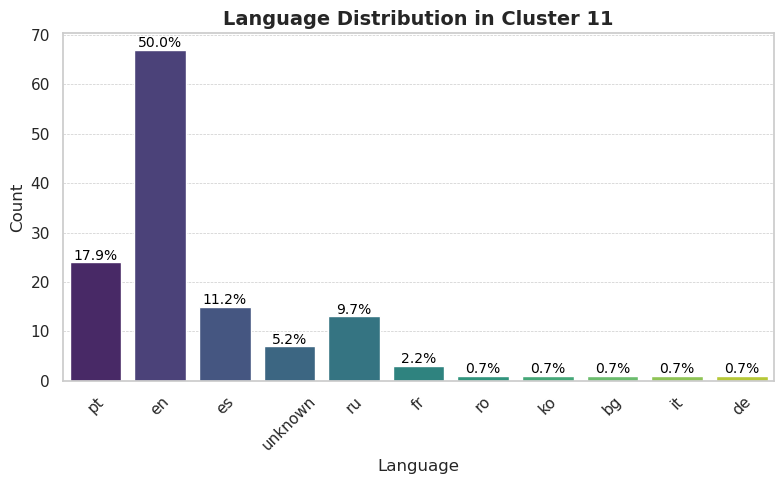

/tmp/ipykernel_7766/78708213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(langs), y=list(counts), palette="viridis")


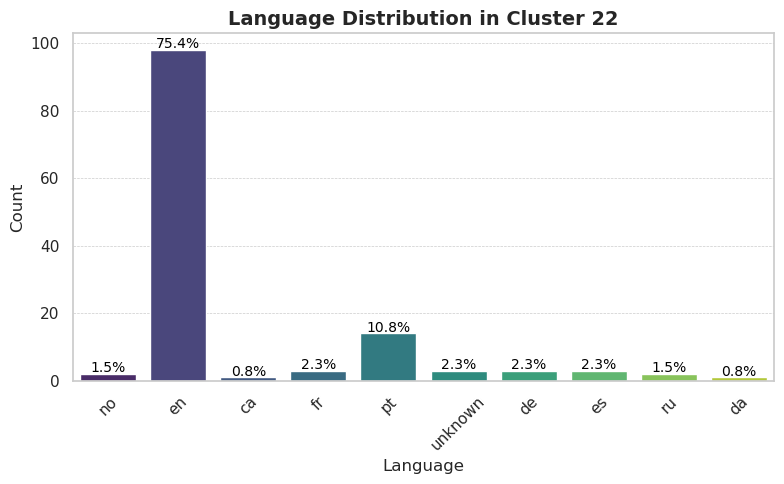

/tmp/ipykernel_7766/78708213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(langs), y=list(counts), palette="viridis")


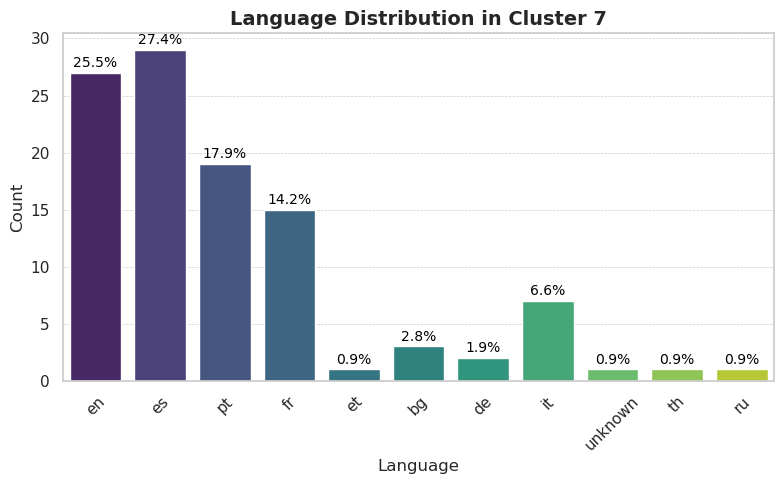

/tmp/ipykernel_7766/78708213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(langs), y=list(counts), palette="viridis")


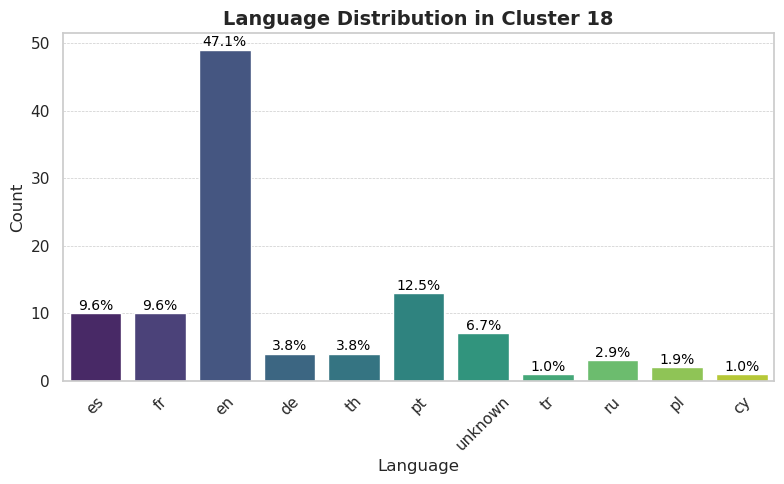

/tmp/ipykernel_7766/78708213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(langs), y=list(counts), palette="viridis")


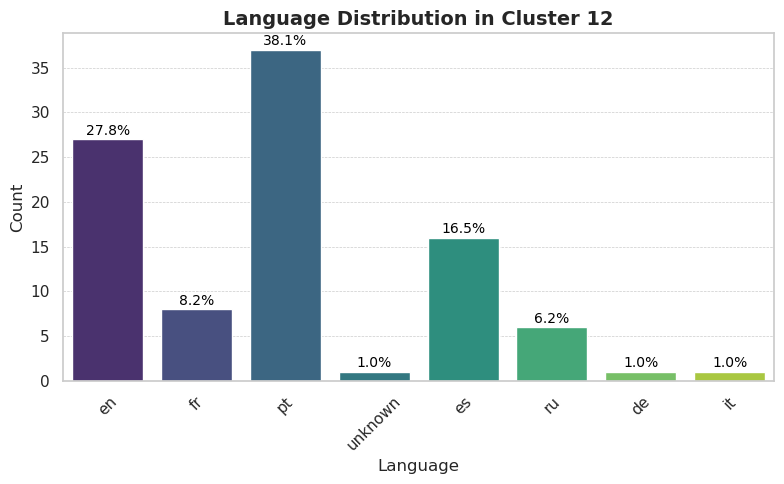

In [21]:
top_clusters = sorted(cluster_lang_counts.items(), key=lambda x: sum(x[1].values()), reverse=True)[:5]

for cluster_id, lang_counter in top_clusters:
    langs, counts = zip(*lang_counter.items())
    total = sum(counts)
    percentages = [f"{(c/total)*100:.1f}%" for c in counts]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(langs), y=list(counts), palette="viridis")
    
    plt.title(f"Language Distribution in Cluster {cluster_id}", fontsize=14, weight='bold')
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    
    # Annotate bars with percentages
    for i, (x, y) in enumerate(zip(langs, counts)):
        plt.text(i, y + 0.5, f"{percentages[i]}", ha='center', fontsize=10, color='black')

    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.show()

In [34]:
import pandas as pd
from collections import defaultdict, Counter

# Load the collab data
collab_df = pd.read_csv("df_collabs.txt", sep="\t")

# Create a mapping of channel -> (category, cluster)
channel_info = {}

for node_id, data in G.nodes(data=True):
    label = data.get("label")
    cluster = data.get("cluster")
    if label:
        channel_info[label] = {
            "cluster": cluster,
            "language": data.get("language", "unknown")
        }

# Add cluster info to collab_df
collab_df["from_cluster"] = collab_df["from"].map(lambda x: channel_info.get(x, {}).get("cluster", -1))
collab_df["from_category"] = collab_df["from_category"].fillna("unknown").astype(str).str.strip()

# Group by cluster and compute category counts
cluster_categories = defaultdict(list)

for _, row in collab_df.iterrows():
    cluster = row["from_cluster"]
    category = row["from_category"]
    if cluster != -1:
        cluster_categories[cluster].append(category)

# Calculate purity
cluster_purities = []

for cluster_id, categories in cluster_categories.items():
    total = len(categories)
    counts = Counter(categories)
    most_common_category, max_count = counts.most_common(1)[0]
    purity = max_count / total
    cluster_purities.append({
        "cluster": cluster_id,
        "size": total,
        "purity": round(purity, 3),
        "majority_category": most_common_category
    })

# Convert to DataFrame and show top clusters
purity_df = pd.DataFrame(cluster_purities)
top_purity_df = purity_df.sort_values(by="size", ascending=False).head(10)
print(top_purity_df)


    cluster  size  purity majority_category
4        12   302   0.742            Gaming
1         7   261   0.766            Gaming
34       11   256   0.848            Gaming
11       18   216   0.676            Gaming
8        22   213   0.300     Entertainment
6        17   154   0.662     Entertainment
22       52   104   0.606            Gaming
14      109   102   0.304            Gaming
27       75   100   0.310     Entertainment
18       42   100   0.810            Gaming


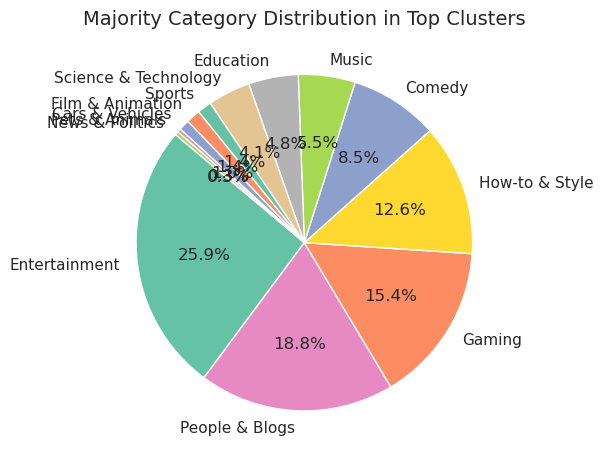

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom category palette
unique_categories = purity_df["majority_category"].unique()
palette = sns.color_palette("Set2", len(unique_categories))
category_colors = dict(zip(unique_categories, palette))

# ---------------------------
# Optional: Pie Chart of Majority Categories
# ---------------------------
category_counts = purity_df["majority_category"].value_counts()

# plt.figure(figsize=(6, 6))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct="%1.1f%%",
    colors=[category_colors[cat] for cat in category_counts.index],
    startangle=140
)
plt.title("Majority Category Distribution in Top Clusters", fontsize=14)
plt.tight_layout()
plt.show()


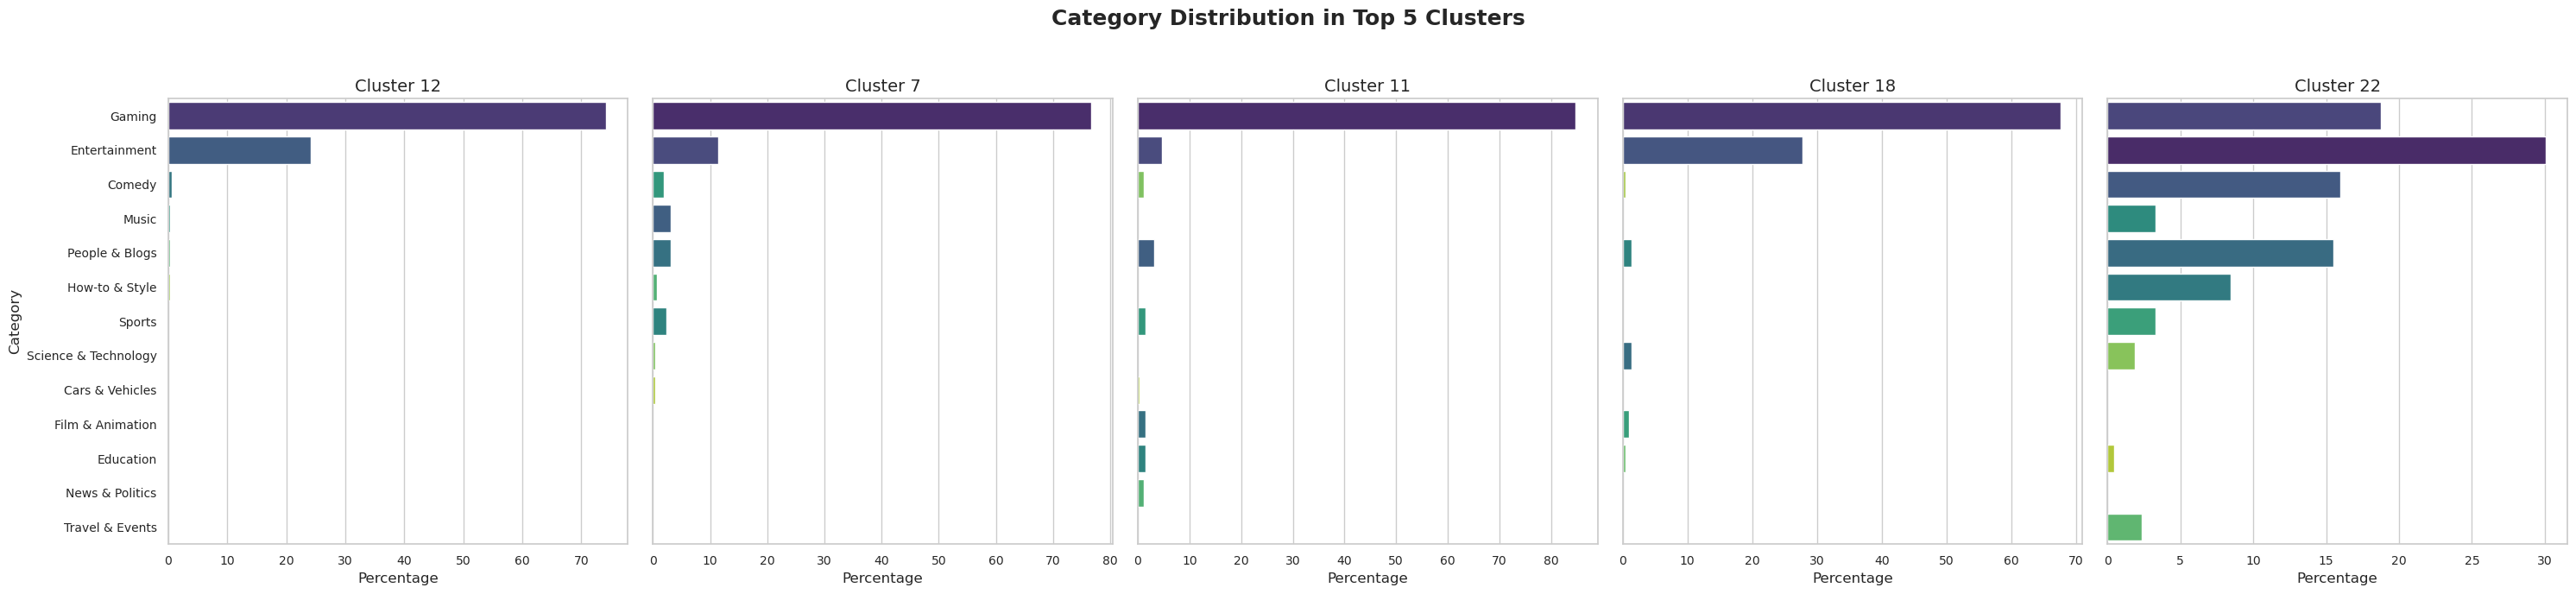

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure correct types
collab_df["from_cluster"] = collab_df["from_cluster"].astype(int)
purity_df["cluster"] = purity_df["cluster"].astype(int)

# Top 5 clusters
top5_clusters = purity_df.sort_values(by="size", ascending=False).head(5)["cluster"].tolist()

# Plot
fig, axes = plt.subplots(1, 5, figsize=(30, 7), sharey=True)

for i, cluster_id in enumerate(top5_clusters):
    sub_df = collab_df[collab_df["from_cluster"] == cluster_id]
    cat_counts = sub_df["from_category"].value_counts(normalize=True) * 100
    
    if not cat_counts.empty:
        sns.barplot(
            y=cat_counts.index,
            x=cat_counts.values,
            hue=cat_counts.index,
            palette="viridis",
            legend=False,
            ax=axes[i]
        )
        axes[i].set_title(f"Cluster {cluster_id}", fontsize=14)
        axes[i].set_xlabel("Percentage", fontsize=12)
        axes[i].tick_params(axis='x', labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)
    else:
        axes[i].text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
        axes[i].set_title(f"Cluster {cluster_id}")

    if i == 0:
        axes[i].set_ylabel("Category", fontsize=12)
    else:
        axes[i].set_ylabel("")

plt.suptitle("Category Distribution in Top 5 Clusters", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
